In [1]:
import json

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import ipywidgets

from stellarpunk import util

# Loading and Preparing Data

In [2]:
df_base = pd.read_json("/tmp/stellarpunk_test.test_basic_collision_avoidance.history.gz", lines=True)
df_base = df_base.join(pd.json_normalize(df_base["o"]).add_prefix("o."))

In [3]:
eids = pd.Series(df_base["eid"].unique())
eids

0    ebe28c7f-c42e-43af-8a04-84ebcc3da68d
1    1148fcd5-c5d2-4f45-8682-a93b03e3ab4a
dtype: object

In [4]:
eids[pd.Series(df_base["eid"].unique()).str.startswith("1aec")]

Series([], dtype: object)

In [5]:
target_eid = df_base["eid"].unique()[0]
df_base = df_base[df_base["eid"] == target_eid].reset_index()
df_base["eid"].unique()

array(['ebe28c7f-c42e-43af-8a04-84ebcc3da68d'], dtype=object)

In [6]:
loc = pd.DataFrame(np.vstack(df_base["loc"]), columns=["loc.x", "loc.y"])
v = pd.DataFrame(np.vstack(df_base["v"]), columns=["v.x", "v.y"])

empty_array = np.empty(len(df_base))
empty_array[:] = np.nan

if "o.t_loc" in df_base:
    o_tloc = pd.DataFrame(np.vstack(df_base["o.t_loc"].apply(lambda x: (np.nan, np.nan) if np.all(np.isnan(x)) else x)), columns=["o.t_loc.x", "o.t_loc.y"])
    o_tv = pd.DataFrame(np.vstack(df_base["o.t_v"].apply(lambda x: (np.nan, np.nan) if np.all(np.isnan(x)) else x)), columns=["o.t_v.x", "o.t_v.y"])
else:
    o_tloc = pd.DataFrame({"o.t_loc": empty_array, "o.t_loc.x": empty_array, "o.t_loc.y": empty_array})
    o_tv = pd.DataFrame({"o.t_v": empty_array, "o.t_v.x": empty_array, "o.t_v.y": empty_array})
    
if "o.ct" in df_base:
    o_ctloc = pd.DataFrame(np.vstack(df_base["o.ct_loc"].apply(lambda x: (np.nan, np.nan) if np.all(np.isnan(x)) else x)), columns=["o.ct_loc.x", "o.ct_loc.y"])
    o_ctdv = pd.DataFrame(np.vstack(df_base["o.ct_dv"].apply(lambda x: (np.nan, np.nan) if np.all(np.isnan(x)) else x)), columns=["o.ct_dv.x", "o.ct_dv.y"])
else:
    o_ctloc = pd.DataFrame({"o.ct_loc": empty_array, "o.ct_loc.x": empty_array, "o.ct_loc.y": empty_array})
    o_ctdv = pd.DataFrame({"o.ct_dv": empty_array, "o.ct_dv.x": empty_array, "o.ct_dv.y": empty_array})
angle = pd.DataFrame(np.vstack(df_base.apply(lambda row: np.array(util.polar_to_cartesian(100, row["a"])), axis=1)), columns=["angle.x", "angle.y"])
df = pd.concat([df_base, loc, v, o_ctloc, o_ctdv, o_tloc, o_tv, angle], axis=1)

if "o.ct" not in df_base:
    df["o.ct"] = empty_array
    df["o.ct_ts"] = empty_array
    df["o.cac"] = empty_array
    df["o.cbdr"] = empty_array
    
if "o.t_loc" not in df_base:
    df["o.cs"] = empty_array

In [7]:
df["speed"] = np.linalg.norm(df[["v.x", "v.y"]], axis=1)
df["o_ct_dist"] = np.linalg.norm(np.vstack(df["loc"]) - np.vstack(df["o.ct_loc"].apply(lambda x: (np.nan, np.nan) if np.all(np.isnan(x)) else x)), axis=1)
df["o_t_dist"] = np.linalg.norm(np.vstack(df["loc"]) - np.vstack(df["o.t_loc"].apply(lambda x: (np.nan, np.nan) if np.all(np.isnan(x)) else x)), axis=1)
df["o_t_speed"] = np.linalg.norm(df[["o.t_v.x", "o.t_v.y"]], axis=1)
df["f_mag"] = df["f"].apply(lambda x:np.linalg.norm(x))

In [8]:
df["o_ct_v.x"] = (df["o.ct_loc.x"].shift(1) - df["o.ct_loc.x"]) / (df["ts"].shift(1) - df["ts"])
df["o_ct_v.y"] = (df["o.ct_loc.y"].shift(1) - df["o.ct_loc.y"]) / (df["ts"].shift(1) - df["ts"])

In [9]:
df

,index,eid,ts,loc,a,v,av,f,t,o,...,o.t_v.y,angle.x,angle.y,speed,o_ct_dist,o_t_dist,o_t_speed,f_mag,o_ct_v.x,o_ct_v.y
0,0,ebe28c7f-c42e-43af-8a04-84ebcc3da68d,0.000000,"[0.0, 2400.0]",0.000000,"[0.0, 0.0]",0.000000e+00,"[-9.18485099360515e-13, -5000.0]",-900000.0,"{'o': 'stellarpunk.orders.GoToLocation', 'nnd'...",...,-135.050934,100.000000,0.000000,0.000000e+00,NaN,2400.000000,135.050934,5000.000000,NaN,NaN
1,1,ebe28c7f-c42e-43af-8a04-84ebcc3da68d,0.016667,"[0.0, 2400.0]",0.000000,"[-7.654042494670959e-18, -0.041666666666666005]",-1.666667e-02,"[12666.66666666667, 0.0]",900000.0,"{'o': 'stellarpunk.orders.GoToLocation', 'ct':...",...,-134.310987,100.000000,0.000000,4.166667e-02,1236.931688,2400.000000,134.310987,12666.666667,NaN,NaN
2,2,ebe28c7f-c42e-43af-8a04-84ebcc3da68d,0.033333,"[-1.275673749111826e-19, 2399.9993055555556]",-0.000278,"[0.10555555555555501, -0.041666666666666005]",-3.469447e-18,"[-3.9094815562343492, -4999.998471595162]",-900000.0,"{'o': 'stellarpunk.orders.GoToLocation', 'nnd'...",...,-135.041054,99.999996,-0.027778,1.134817e-01,NaN,2399.999306,135.041054,5000.000000,NaN,NaN
3,3,ebe28c7f-c42e-43af-8a04-84ebcc3da68d,0.050000,"[0.0017592592592590001, 2399.998611111111]",-0.000278,"[0.10552297654258601, -0.083333320596626]",-1.666667e-02,"[-3.934700071718691, -4999.998451813295]",-900000.0,"{'o': 'stellarpunk.orders.GoToLocation', 'nnd'...",...,-134.301175,99.999996,-0.027778,1.344602e-01,NaN,2399.998611,134.301175,5000.000000,NaN,NaN
4,4,ebe28c7f-c42e-43af-8a04-84ebcc3da68d,0.066667,"[0.003517975534969, 2399.9972222224346]",-0.000556,"[0.10549018737532201, -0.12499997436173702]",-3.333333e-02,"[-3.960518169795992, -4999.998431429337]",-900000.0,"{'o': 'stellarpunk.orders.GoToLocation', 'nnd'...",...,-133.549352,99.999985,-0.055556,1.635640e-01,NaN,2399.997222,133.549352,5000.000000,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2092,2092,ebe28c7f-c42e-43af-8a04-84ebcc3da68d,34.866667,"[369.9353434285337, 928.2676465268131]",-4.956175,"[-4.815388896962498, -12.083110732452258]",3.985835e-02,"[185103.49663636708, 464474.6446610304]",-900000.0,"{'o': 'stellarpunk.orders.GoToLocation', 'nnd'...",...,0.000000,24.137820,97.043112,1.300729e+01,NaN,999.266222,0.000000,500000.000000,NaN,NaN
2093,2093,ebe28c7f-c42e-43af-8a04-84ebcc3da68d,34.883333,"[369.85508694691765, 928.066261347939]",-4.955510,"[-3.272859758326106, -8.21248869361034]",2.319168e-02,"[185103.49663636708, 464474.6446610304]",-900000.0,"{'o': 'stellarpunk.orders.GoToLocation', 'nnd'...",...,0.000000,24.073348,97.059126,8.840621e+00,NaN,999.049434,0.000000,500000.000000,NaN,NaN
2094,2094,ebe28c7f-c42e-43af-8a04-84ebcc3da68d,34.900000,"[369.8005392842789, 927.9293865363788]",-4.955124,"[-1.7303306196897141, -4.34186665476842]",6.525016e-03,"[185103.49663636708, 464474.6446610304]",-900000.0,"{'o': 'stellarpunk.orders.GoToLocation', 'nnd'...",...,0.000000,24.035830,97.068424,4.673954e+00,NaN,998.902090,0.000000,500000.000000,NaN,NaN
2095,2095,ebe28c7f-c42e-43af-8a04-84ebcc3da68d,34.916667,"[369.7717004406174, 927.8570220921328]",-4.955015,"[-0.187801481053321, -0.4712446159265]",-1.014165e-02,"[22536.177726398582, 56549.3539111801]",-900000.0,"{'o': 'stellarpunk.orders.GoToLocation', 'nnd'...",...,0.000000,24.025274,97.071037,5.072878e-01,NaN,998.824191,0.000000,60874.532723,NaN,NaN


# Basic Ship Vitals

## Position and Heading

In [10]:
def plot_location_chart(max_time):
    sample = df[df["ts"] <= max_time].iloc[::50]
    plt.quiver(sample["loc.x"], sample["loc.y"], sample["angle.x"], sample["angle.y"])#, scale=100)
    plt.scatter(sample["o.t_loc.x"], sample["o.t_loc.y"])
    #center = (0,2500)
    #radius = 10000
    #plt.xlim(center[0]-radius,center[0]+radius)
    #plt.ylim(center[1]-radius,center[1]+radius)

ipywidgets.interact(plot_location_chart, max_time=ipywidgets.FloatSlider(value=df["ts"].max(), min=df["ts"].min(), max=df["ts"].max(), continuous_update=False))

interactive(children=(FloatSlider(value=34.933333333332634, continuous_update=False, description='max_time', m…

<function __main__.plot_location_chart(max_time)>

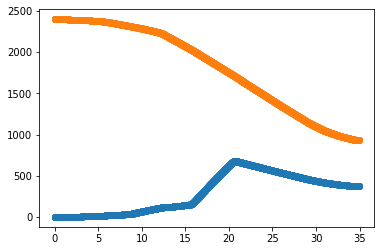

In [11]:
plt.scatter(df["ts"], df["loc.x"])
plt.scatter(df["ts"], df["loc.y"])

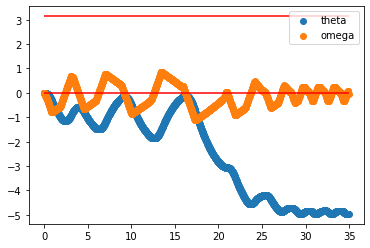

In [12]:
plt.scatter(df["ts"], df["a"], label="theta")
plt.scatter(df["ts"], df["av"], label="omega")
plt.hlines(np.pi, df["ts"].min(), df["ts"].max(), color="red")
plt.hlines(0, df["ts"].min(), df["ts"].max(), color="red")
plt.legend()

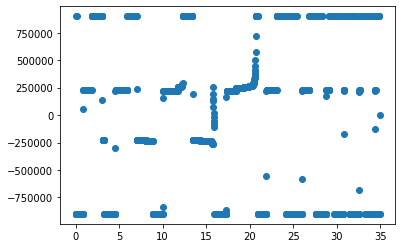

In [13]:
plt.scatter(df["ts"], df["t"])

## Velocity and Acceleration

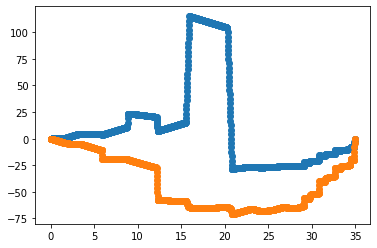

In [14]:
plt.scatter(df["ts"], df["v.x"])
plt.scatter(df["ts"], df["v.y"])

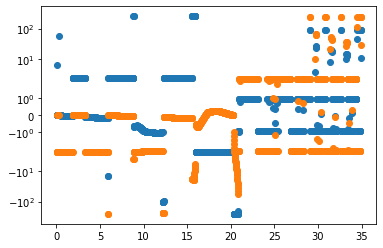

In [15]:
#plt.scatter(df["ts"], (df["v.x"] - df["v.x"].shift(-1)))#/(df["ts"]-df["ts"].shift(-1)))
plt.scatter(df["ts"], (df["v.x"].shift(1) - df["v.x"]) / (df["ts"].shift(1) - df["ts"]))
plt.scatter(df["ts"], (df["v.y"].shift(1) - df["v.y"]) / (df["ts"].shift(1) - df["ts"]))
plt.yscale("symlog")

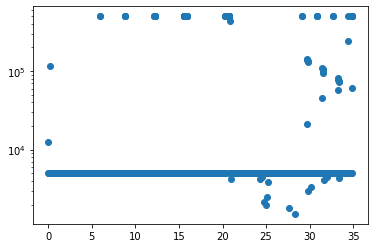

In [16]:
plt.scatter(df["ts"], df["f_mag"])
plt.yscale("log")

# Behavior Monitoring

In [17]:
def plot_collision_info(hist_length, max_time):
    sample = df[(df["ts"] >= max_time - hist_length) & (df["ts"] <= max_time)]
    plt.scatter(sample["ts"], (~(sample["o.ct"].isna())).astype(int), label="ct")
    plt.scatter(sample["ts"], sample["o.cs"].fillna(0).astype(int)+0.05, label="cs")
    plt.scatter(sample["ts"], sample["o.cac"].fillna(0).astype(int)+0.1, label="cac")
    plt.scatter(sample["ts"], sample["o.cbdr"].fillna(0).astype(int)+0.15, label="cbdr")
    plt.legend()

ipywidgets.interact(plot_collision_info, hist_length=ipywidgets.FloatSlider(value=5, min=0, max=df["ts"].max()-df["ts"].min(), continuous_update=False), max_time=ipywidgets.FloatSlider(value=df["ts"].max(), min=df["ts"].min(), max=df["ts"].max()+.1, continuous_update=False))

interactive(children=(FloatSlider(value=5.0, continuous_update=False, description='hist_length', max=34.933333…

<function __main__.plot_collision_info(hist_length, max_time)>

## Target Location

In [18]:
if np.any(~df["o.t_loc"].isna()):
    x = df.groupby(["o.t_loc.x", "o.t_loc.y"])["ts"].describe().sort_values(["min"])
x

,,count,mean,std,min,25%,50%,75%,max
o.t_loc.x,o.t_loc.y,,,,,,,,
0.0,0.0,2096.0,17.458333,10.08679,0.0,8.729167,17.458333,26.1875,34.916667


In [19]:
if np.any(~df["o.t_loc"].isna()):
    x = df.groupby(["o.t_loc.x", "o.t_loc.y"])["o_t_dist"].describe()
x

,,count,mean,std,min,25%,50%,75%,max
o.t_loc.x,o.t_loc.y,,,,,,,,
0.0,0.0,2096.0,1860.19443,473.845071,998.824191,1436.592693,1947.863154,2314.55091,2400.0


(998.8241906824375, 998.8241906824375)

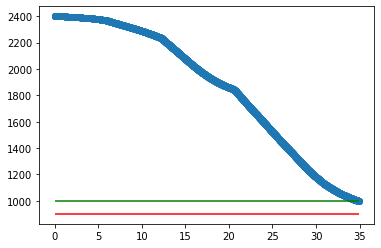

In [20]:
plt.scatter(df["ts"], df["o_t_dist"])
plt.hlines(1000, df["ts"].min(), df["ts"].max(), color="green")
plt.hlines(900, df["ts"].min(), df["ts"].max(), color="red")
df["o_t_dist"].min(),df[df["ts"] > df["ts"].max()-1]["o_t_dist"].min()

(0.0, 141.80348096595384)

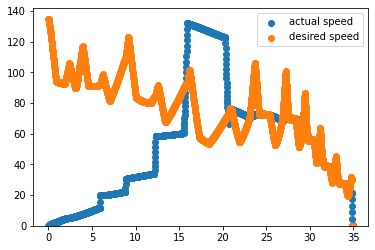

In [21]:
plt.scatter(df["ts"], df["speed"], label="actual speed")
plt.scatter(df["ts"], df["o_t_speed"], label="desired speed")
plt.legend()
plt.ylim(0)

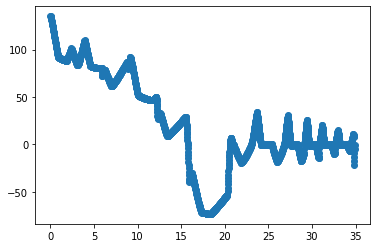

In [22]:
plt.scatter(df["ts"], df["o_t_speed"] - df["speed"])

## Collision Avoidance

In [23]:
if np.any(~df["o.ct"].isna()):
    x = df.groupby("o.ct")["ts"].describe()
else:
    x = "no collision threats"
x

,count,mean,std,min,25%,50%,75%,max
o.ct,,,,,,,,
1148fcd5-c5d2-4f45-8682-a93b03e3ab4a,482.0,9.536929,4.585113,0.016667,6.470833,8.475,13.9125,15.916667


In [24]:
if np.any(~df["o.ct"].isna()):
    x = df.groupby("o.ct")["o_ct_dist"].describe()
else:
    x = "no collision threats"
x

,count,mean,std,min,25%,50%,75%,max
o.ct,,,,,,,,
1148fcd5-c5d2-4f45-8682-a93b03e3ab4a,482.0,1119.446795,97.483566,944.256963,1028.610824,1168.277508,1201.505038,1236.931688


944.2569631667207

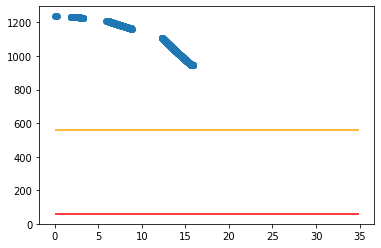

In [25]:
plt.scatter(df["ts"], df["o_ct_dist"])
plt.hlines(60+500, df["ts"].min(), df["ts"].max(), color="orange")
plt.hlines(60, df["ts"].min(), df["ts"].max(), color="red")
plt.ylim(0)
df["o_ct_dist"].min()

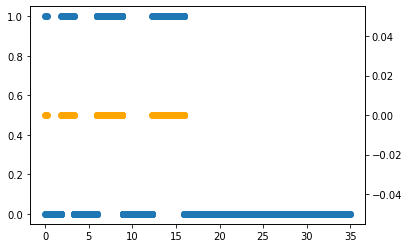

In [26]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.scatter(df["ts"], 1-df["o.ct"].isna().astype(int))
ax2.scatter(df["ts"], df["ts"] - df["o.ct_ts"], color="orange")

#ax2.set_ylim(0,(df["ts"] - df["o.ct_ts"]).max()*1.2)

# History Visualization

## Position and Velocity

In [27]:
def plot_collision_chart(hist_length=df["ts"].max(), max_time=df["ts"].max(), show_tloc=True):
    #fig, ax = plt.subplots()
    plt.figure(figsize=(10, 10))
    sample = df[(df["ts"] >= max_time - hist_length) & (df["ts"] <= max_time)].iloc[::10]
    plt.quiver(sample["loc.x"], sample["loc.y"], sample["v.x"], sample["v.y"], label="v")
    ctdv_df = sample[~(sample["o.ct_dv"].isna())]
    plt.quiver(ctdv_df["loc.x"], ctdv_df["loc.y"], ctdv_df["o.ct_dv.x"], ctdv_df["o.ct_dv.y"], label="ctdv", color="orange")
    plt.quiver(sample["loc.x"], sample["loc.y"], sample["o.t_v.x"], sample["o.t_v.y"], label="tv", color="purple")
    
    plt.quiver(sample["o.ct_loc.x"], sample["o.ct_loc.y"], sample["o_ct_v.x"], sample["o_ct_v.y"])
    cmap = plt.get_cmap('viridis')
    for x, c in zip(df["o.ct"].unique(), cmap(np.linspace(0, 1, len(df["o.ct"].unique())))):
        if not isinstance(x, str):
            continue
        ct = sample[sample["o.ct"] == x]
        if len(ct) == 0:
            continue
        plt.scatter(ct["o.ct_loc.x"], ct["o.ct_loc.y"], color=c, label=x[:8])
    if show_tloc:
        plt.scatter(sample["o.t_loc.x"], sample["o.t_loc.y"], label="t_loc")
        for (tloc_x, tloc_y) in sample.groupby(["o.t_loc.x", "o.t_loc.y"])["o.t_loc"].min():
            arrival_dist = plt.Circle((tloc_x, tloc_y), 1000, color="green", fill=False)
            min_dist = plt.Circle((tloc_x, tloc_y), 900, color="red", fill=False)
            plt.gca().add_patch(arrival_dist)
            plt.gca().add_patch(min_dist)
    plt.axis('equal')
    #center = (-33555, -5000)
    #radius = 15000
    #plt.xlim(center[0]-radius,center[0]+radius)
    #plt.ylim(center[1]-radius,center[1]+radius)

    plt.legend()
    plt.show()
    
ipywidgets.interact(
    plot_collision_chart,
    hist_length=ipywidgets.FloatSlider(value=5, min=0, max=df["ts"].max()-df["ts"].min(), continuous_update=False),
    max_time=ipywidgets.FloatSlider(value=df["ts"].max(), min=df["ts"].min(), max=df["ts"].max(), continuous_update=False),
    show_tloc=ipywidgets.Checkbox(value=True),
)

interactive(children=(FloatSlider(value=5.0, continuous_update=False, description='hist_length', max=34.933333…

<function __main__.plot_collision_chart(hist_length=34.933333333332634, max_time=34.933333333332634, show_tloc=True)>

## Position and Heading

In [28]:
def plot_collision_chart(hist_length=df["ts"].max(), max_time=df["ts"].max()):
    sample = df[(df["ts"] >= max_time - hist_length) & (df["ts"] <= max_time)].iloc[::50]
    plt.quiver(sample["loc.x"], sample["loc.y"], sample["angle.x"], sample["angle.y"], label="ship")
    ctdv_df = sample[~(sample["o.ct_dv"].isna())]
    plt.quiver(ctdv_df["loc.x"], ctdv_df["loc.y"], ctdv_df["o.ct_dv.x"], ctdv_df["o.ct_dv.y"], label="ctdv", color="orange")
    plt.quiver(sample["loc.x"], sample["loc.y"], sample["o.t_v.x"], sample["o.t_v.y"], label="tv", color="purple")
    cmap = plt.get_cmap('viridis')
    #for x, c in zip(df["o.ct"].unique(), cmap(np.linspace(0, 1, len(sample["o.ct"].unique())))):
    #    print(x)
    #    if not isinstance(x, str):
    #        continue
    #    ct = sample[sample["o.ct"] == x]
    #    plt.scatter(ct["o.ct_loc.x"], ct["o.ct_loc.y"], color=c, label=x[:8])
    #plt.scatter(sample["o.t_loc.x"], sample["o.t_loc.y"], label="t_loc")
    #plt.axis('square')
    #center = (-33555, -5000)
    #radius = 15000
    #plt.xlim(center[0]-radius,center[0]+radius)
    #plt.ylim(center[1]-radius,center[1]+radius)

    plt.legend()
    plt.axis('equal')
    plt.show()
    
ipywidgets.interact(plot_collision_chart, hist_length=ipywidgets.FloatSlider(value=5, min=0, max=df["ts"].max()-df["ts"].min(), continuous_update=False), max_time=ipywidgets.FloatSlider(value=df["ts"].max(), min=df["ts"].min(), max=df["ts"].max(), continuous_update=False))

interactive(children=(FloatSlider(value=5.0, continuous_update=False, description='hist_length', max=34.933333…

<function __main__.plot_collision_chart(hist_length=34.933333333332634, max_time=34.933333333332634)>

# 